In [1]:
import numpy as np
import pandas as pd
from uncertainties import unumpy, ufloat

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import seaborn as sns

import os
import glob

from lmfit.models import Model, ConstantModel, PolynomialModel, PowerLawModel

In [2]:
# https://stackoverflow.com/questions/22348756/upright-mu-in-plot-label-retaining-original-tick-fonts
# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib

import matplotlib
from matplotlib import rc

matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family':'sans-serif'})

## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})

#params = {'text.latex.preamble':[r'\usepackage{siunitx}',
#                                 r'\usepackage{amsmath}',
#                                 r'\usepackage{physics}',
#                                 r'\usepackage{sfmath}',
#                                 r'\sisetup{detect-all=true}']}

params = {'text.latex.preamble':[r'\usepackage{siunitx}',
                                 r'\usepackage{amsmath}',
                                 r'\usepackage{physics}',
                                 r'\usepackage{helvet}',
                                 r'\usepackage{sansmath}',
                                 r'\sansmath',
                                 r'\sisetup{detect-all}']}
plt.rcParams.update(params)

# Location of nu=0 peak vs. n

In [3]:
n_list = np.arange(30, 45+1, 1)
R_list = np.zeros(len(n_list))
E_list = np.zeros(len(n_list))

for idx, n in enumerate(n_list):
    sheet_name = 'n'+str(n)
    wvf = pd.read_excel('wvf_87Sr_without_ion_atom-nu0.xlsx', sheet_name = sheet_name, header=0)
    
    nu_0_max_idx = np.abs(wvf['R psi(R)']).idxmax(axis=0)
    
    R_list[idx] = wvf['R (nm)'][nu_0_max_idx]
    E_list[idx] = wvf['E (MHz)'][0]

In [4]:
def delta(n):
    d0 = ufloat(3.371, 0.002)
    d2 = ufloat(0.5, 0.2)
    d4 = ufloat(-1, 2)*1E1
    return d0 + d2/(n-d0)**2 + d4/(n-d0)**4

# nu=0 radius vs. n (1.87 factor is from Shuhei)
def R_n_nu0(n):
    A0 = ufloat(5.29177210903, 0.00000000080)*1E-11 # [m] Bohr radius
    R = A0 * 1.87*(n-delta(n))**2
    return R*1E9

def binding_energy(n, A, B):
    out = A + B/(n - delta(n))**6
    return unumpy.nominal_values(out)

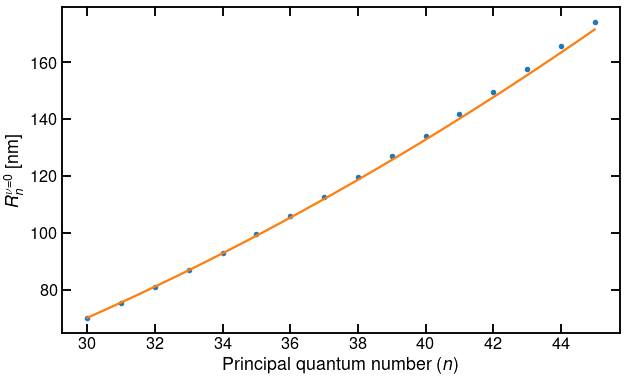

In [5]:
sns.set_context('talk')

fig = plt.figure(figsize=(10,6))
ax = plt.gca()

########################################
# Global options

########################################
# Plot
plt.plot(n_list, R_list, '.')

n = np.linspace(min(n_list), max(n_list), endpoint=True)
R = R_n_nu0(n)
R_nom = unumpy.nominal_values(R)
R_unc = unumpy.std_devs(R)
plt.plot(n, R_nom)
plt.fill_between(n, R_nom+R_unc, R_nom-R_unc)

########################################
# Plot options

# Axis tick options
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(which='both', axis='both', direction='in')

# Axis labels
ax.set_xlabel(r'Principal quantum number ($n$)')
ax.set_ylabel(r'$R^{\nu=0}_{n}$ [\si{\nm}]')

#plt.legend(frameon=False)

plt.show()

### Fitting to get 1/n^6 scaling factors for binding energy

[[Model]]
    Model(binding_energy)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 16
    # variables        = 2
    chi-square         = 0.07213599
    reduced chi-square = 0.00515257
    Akaike info crit   = -82.4286545
    Bayesian info crit = -80.8834771
[[Variables]]
    A:  0.15887779 +/- 0.02831376 (17.82%) (init = 0)
    B: -1.7005e+10 +/- 23537429.4 (0.14%) (init = -4.8e+10)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, B) = -0.773



C:\Users\reyalp\Anaconda3\lib\site-packages\matplotlib\ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


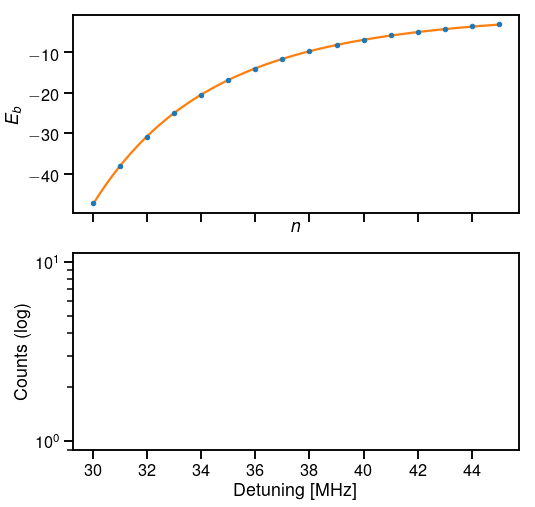

In [6]:
#data = pol_data
plot_components = False
plot_initial_guess = False

# Choosing a range to fit over
xmin = min(n_list)
xmax = max(n_list)

#xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
#ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
#ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

xdata = n_list
ydata = E_list

# Specify fit model
#bg = PolynomialModel(degree=0, prefix='bg_')
#sig = PowerLawModel(prefix='sig_')

#fit_model = bg + 1/sig
fit_model = Model(binding_energy)
fit_params = fit_model.make_params()

fit_params['A'].set(0, vary=True)
#fit_params['bg_c1'].set(0, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['B'].set(-4.8E10, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, n=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, n=xdata)
#dely = fit_result.eval_uncertainty(n=xdata)
yfit = fit_model.eval(fit_result.params, n=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

#axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].errorbar(xdata, ydata, fmt = '.', capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel(r'$n$')
axs[0].set_ylabel(r'$E_b$')

axs[1].set_yscale('log')
#axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].errorbar(xdata, ydata, fmt='.', capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [7]:
fit_A = fit_result.params['A'].value
fit_B = fit_result.params['B'].value
print('A: ' + str(fit_A))
print('B: ' + str(fit_B))

A: 0.15887779279867884
B: -17005380141.997108


# Plot for PhD thesis

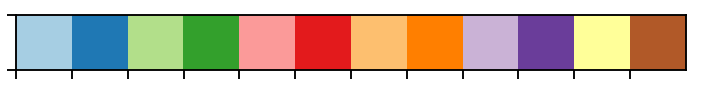

In [8]:
sns.palplot(sns.color_palette("Paired"))

# Molecular potential and nu=0 wave function vs. n

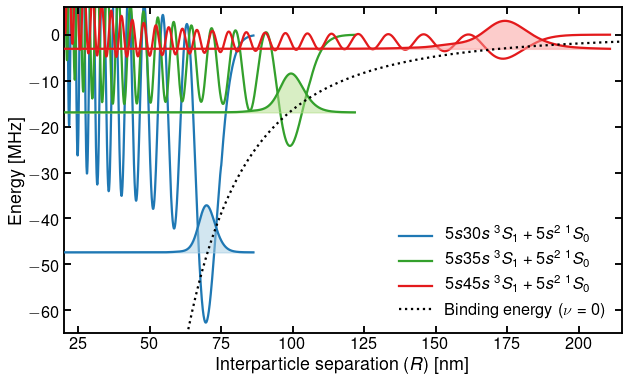

In [30]:
sns.set_context('talk')

fig = plt.figure(figsize=(10,6))
ax = plt.gca()

########################################
# Global options
fill_alpha = 0.5

########################################
# n=30
n = 30
sheet_name = 'n'+str(n)
pot_label = r'${5s30s}{\;}^{3}{S}_{1} + {5s^2}{\;}^{1}{S}_{0}$'
pot_line_color = sns.color_palette("Paired")[1]
wvf_line_color = sns.color_palette("Paired")[1]
wvf_fill_color = sns.color_palette("Paired")[0]

pot = pd.read_excel('pot_87Sr_without_ion_atom.xlsx', sheet_name = sheet_name, header=0)
wvf = pd.read_excel('wvf_87Sr_without_ion_atom-nu0.xlsx', sheet_name = sheet_name, header=0)

wvf_scale = -1E2
wvf_offset = wvf['E (MHz)'][0]

plt.plot(pot['R (nm)'], pot['Energy shift (MHz)'],
         color=pot_line_color, label=pot_label, zorder=1)
plt.plot(wvf['R (nm)'], wvf_scale*wvf['R psi(R)'] + wvf_offset,
         color=wvf_line_color, label='_nolegend_', zorder=3)
plt.fill_between(wvf['R (nm)'], wvf_scale*wvf['R psi(R)'] + wvf_offset, wvf_offset,
                 color=wvf_fill_color, alpha=fill_alpha, zorder=2)

########################################
# n=35
n = 35
sheet_name = 'n'+str(n)
pot_label = r'${5s35s}{\;}^{3}{S}_{1} + {5s^2}{\;}^{1}{S}_{0}$'
pot_line_color = sns.color_palette("Paired")[3]
wvf_line_color = sns.color_palette("Paired")[3]
wvf_fill_color = sns.color_palette("Paired")[2]

pot = pd.read_excel('pot_87Sr_without_ion_atom.xlsx', sheet_name = sheet_name, header=0)
wvf = pd.read_excel('wvf_87Sr_without_ion_atom-nu0.xlsx', sheet_name = sheet_name, header=0)

wvf_scale = 1E2
wvf_offset = wvf['E (MHz)'][0]

plt.plot(pot['R (nm)'], pot['Energy shift (MHz)'],
         color=pot_line_color, label=pot_label, zorder=1)
plt.plot(wvf['R (nm)'], wvf_scale*wvf['R psi(R)'] + wvf_offset,
         color=wvf_line_color, label='_nolegend_', zorder=3)
plt.fill_between(wvf['R (nm)'], wvf_scale*wvf['R psi(R)'] + wvf_offset,
                 wvf_offset, color=wvf_fill_color, alpha=fill_alpha, zorder=2)

########################################
# n=45
n = 45
sheet_name = 'n'+str(n)
pot_label = r'${5s45s}{\;}^{3}{S}_{1} + {5s^2}{\;}^{1}{S}_{0}$'
pot_line_color = sns.color_palette("Paired")[5]
wvf_line_color = sns.color_palette("Paired")[5]
wvf_fill_color = sns.color_palette("Paired")[4]

pot = pd.read_excel('pot_87Sr_without_ion_atom.xlsx', sheet_name = sheet_name, header=0)
wvf = pd.read_excel('wvf_87Sr_without_ion_atom-nu0.xlsx', sheet_name = sheet_name, header=0)

wvf_scale = -1E2
wvf_offset = wvf['E (MHz)'][0]

plt.plot(pot['R (nm)'], pot['Energy shift (MHz)'],
         color=pot_line_color, label=pot_label, zorder=1)
plt.plot(wvf['R (nm)'], wvf_scale*wvf['R psi(R)'] + wvf_offset,
         color=wvf_line_color, label='_nolegend_', zorder=3)
plt.fill_between(wvf['R (nm)'], wvf_scale*wvf['R psi(R)'] + wvf_offset,
                 wvf_offset, color=wvf_fill_color, alpha=fill_alpha, zorder=2)

########################################
# Binding energy vs. radius
n = np.linspace(20, 60, 1000)
R_ULRRM = unumpy.nominal_values(R_n_nu0(n))
E_ULRRM = binding_energy(n, fit_A, fit_B)
plt.plot(R_ULRRM, E_ULRRM, ':', color='black', zorder=4, label=r'Binding energy ($\nu = 0$)')

########################################
# Plot options

# Axis limits
ax.set_xlim((20, 215))
ax.set_ylim(bottom=-65, top=6)

# Axis tick options
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(which='both', axis='both', direction='in', length=7)

# Axis labels
ax.set_xlabel(r'Interparticle separation ($R$) [\si{\nm}]')
ax.set_ylabel(r'Energy [\si{\MHz}]')

plt.legend(frameon=False)

plt.savefig('vary_n-nu0.pdf', bbox_inches='tight', transparent=True)

plt.show()